## Load 'Price Paid' dataset

In [1]:
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
#read price paid data
df = pd.read_csv('pp-complete.csv', header=None)

In [3]:
df.head()

0      1                 2         3   \
0  {2A289E9F-6BB5-CDC8-E050-A8C063054829}  36995  1995-03-24 00:00  SE19 3NF   
1  {2A289E9F-6BBA-CDC8-E050-A8C063054829}  25000  1995-03-31 00:00   E16 1LG   
2  {2A289E9F-6BC5-CDC8-E050-A8C063054829}  25500  1995-05-17 00:00   EN3 6EA   
3  {2A289E9F-7DE9-CDC8-E050-A8C063054829}  42000  1995-04-21 00:00   N13 4RS   
4  {2A289E9F-7DF0-CDC8-E050-A8C063054829}  43000  1995-06-30 00:00  RM10 7NU   

  4  5  6            7    8              9    10        11  \
0  F  N  L  CROWN POINT   14    BEULAH HILL  NaN    LONDON   
1  F  N  L            9  NaN  POLLARD CLOSE  NaN    LONDON   
2  F  N  L           33  NaN   BRIDLE CLOSE  NaN   ENFIELD   
3  T  N  L           87  NaN   RUSSELL ROAD  NaN    LONDON   
4  T  N  F           45  NaN  BOSWORTH ROAD  NaN  DAGENHAM   

                     12              13 14 15  
0               CROYDON  GREATER LONDON  A  A  
1                NEWHAM  GREATER LONDON  A  A  
2               ENFIELD  GREATER LONDON  A  A  
3               ENFIELD  GREATER LONDON  A  A  
4  BARKING AND DAGENHAM  GREATER LONDON  A  A

In [4]:
#rename columns
df.rename(columns={1: 'Price', 2: 'Date', 3: 'Postcode', 4: 'Type', 11:'loc1', 12:'loc2', 13:'loc3'}, inplace=True)

In [5]:
#select specific columns
df = df[['Price', 'Date', 'Type', 'Postcode', 'loc1', 'loc2', 'loc3']]

In [6]:
#create year columns
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [7]:
#select years from 2010 to 2021
df = df[(df.Year >= 2010) & (df.Year <= 2021)]

In [8]:
#check data counts for property types
df.Type.value_counts()

T    3058834
S    2873180
D    2552490
F    2002521
O     390384
Name: Type, dtype: int64

In [9]:
#remove type 'O' due to limited data
df = df[df.Type != 'O']

In [10]:
#check number of rows/columns
df.shape

(10487025, 8)

## Load Postcode dataset

In [11]:
#read postcode information for Elmbridge
dfp = pd.read_csv('Elmbridge postcodes.csv')

In [12]:
#check columns
dfp.columns

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'Ward', 'Parish', 'Introduced', 'Terminated', 'Altitude',
       'Country', 'Last Updated', 'Quality', 'LSOA Code', 'LSOA Name'],
      dtype='object')

## Find Clusters

In [13]:
#set lat/long as features for clustering
features = dfp[['Latitude', 'Longitude']]

In [14]:
#find optimum cluster count using initera_ parameter
x=[]
y=[]
for cluster_num in range(20, 300, 20):
    kmeans = KMeans(
        init="random",
        n_clusters=cluster_num,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(features)
    x.append(cluster_num)
    y.append(kmeans.inertia_)

In [15]:
import matplotlib.pyplot as plt

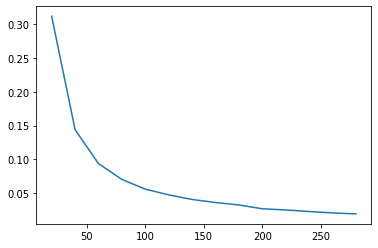

In [16]:
#plot results
plt.plot(x, y)
plt.show()

In [17]:
#eblow occurs at ~100 clusters so use this value
num_clusters = 100

#initialize KMeans
kmeans = KMeans(
    init="random",
    n_clusters=num_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [18]:
#fit model, find labels and add to dataframe
kmeans.fit(features)
labels = kmeans.labels_
dfp['cluster'] = labels

#find centers
centers = kmeans.cluster_centers_
df_centers = pd.DataFrame(centers, columns = ['Lat', 'Lon']).reset_index()
df_centers = df_centers.rename(columns={'index':'cluster'})

#add centers to dataframe
dfp = pd.merge(dfp, df_centers, on='cluster')

## Create Dataframe with 'Price Paid' Data for Elmbridge

In [19]:
#extract Elmbridge data by merging price paid data 
dfall = pd.merge(df, dfp, on='Postcode')

In [20]:
#check number of rows/columns
dfall.shape

(30037, 27)

In [21]:
#check data counts for each Ward
dfall.Ward.value_counts()

Weybridge Riverside               2165
Walton Central                    2123
Hersham Village                   2101
Oxshott and Stoke D'Abernon       2030
Weybridge St George's Hill        2027
Oatlands and Burwood Park         2017
Molesey East                      1934
Cobham and Downside               1927
Esher                             1926
Thames Ditton                     1907
Walton South                      1895
Hinchley Wood and Weston Green    1769
Molesey West                      1715
Walton North                      1694
Long Ditton                       1430
Claygate                          1377
Name: Ward, dtype: int64

## Examine Clusters

In [22]:
#number of clusters from kmeans
cluster_count = len(dfall.cluster.unique())
print('Number of cluster:', cluster_count)

Number of cluster: 94


Average number of postcodes per cluster: 32.308510638297875


<AxesSubplot:>

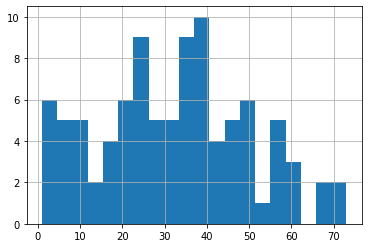

In [23]:
#average number of postcodes per cluster
print('Average number of postcodes per cluster:', dfall.groupby(['cluster'])['Postcode'].nunique().mean())
dfall.groupby(['cluster'])['Postcode'].nunique().hist(bins=20)

In [24]:
#show number of 'price paid' data points compared with number of postcodes in each cluster
x = dfall.groupby(['cluster'])['Postcode'].nunique().values
y = dfcount_clusters = dfall[dfall.Year >= 2010].groupby(['cluster'])['Price'].count().values

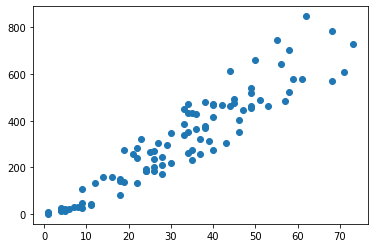

In [25]:
#plot results
plt.scatter(x, y)
plt.show()

## Map Clusters for Elmbridge

In [26]:
#pip install folium

In [27]:
import folium

In [28]:
#define lat/long coordinates from postcode dataframe
latlon = []
for i in range(dfp.shape[0]):
    coord = (dfp.Latitude.iloc[i], dfp.Longitude.iloc[i])
    latlon.append(coord)

In [29]:
#create folium map for post codes by Ward
dfp['color'] = ''
coord = []
ncoord = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'black',
          'red', 'blue', 'green', 'white', 'orange', 'yellow', 'brown', 'cyan']

for i, ward in enumerate(dfp.Ward.unique()):
    dfp.loc[dfp.Ward == ward, 'color'] = colors[i]

latlon = dfp[['Latitude','Longitude','color']].values.tolist()
    
mapit = None
#mapit = folium.Map(location = [51.432057, -0.511055])
mapit = folium.Map()

elm_geo='Elm_wards.json'
folium.TopoJson(open(elm_geo),
    'objects.E07000207',
    name='topojson'
).add_to(mapit)

for coord in latlon:
    folium.CircleMarker(location=[coord[0], coord[1]], radius=3, weight=2, color=coord[2]).add_to(mapit)

mapit.fit_bounds(mapit.get_bounds())
mapit

In [30]:
#create folium map for clusters

coord = []
ncoord = []

latlon = df_centers[['Lat', 'Lon']].values.tolist()
    
mapclusters = None
mapclusters = folium.Map()

elm_geo='Elm_wards.json'
folium.TopoJson(open(elm_geo),
    'objects.E07000207',
    name='topojson'
).add_to(mapclusters)

for coord in latlon:
    folium.CircleMarker(location=[coord[0], coord[1]], fill=True, fill_opacity=0.5,
                        radius=10, weight=2, color='blue', fill_color = 'blue').add_to(mapclusters)

mapclusters.fit_bounds(mapit.get_bounds())
mapclusters

In [31]:
df_cluster_data = dfall.groupby(['cluster'])['Price'].count().reset_index()
df_cluster_data = df_cluster_data.rename(columns={'Price': 'Price_count'})

In [32]:
df_centers

cluster        Lat       Lon
0         0  51.338993 -0.351154
1         1  51.396555 -0.383532
2         2  51.381786 -0.452896
3         3  51.373556 -0.451209
4         4  51.398458 -0.368859
..      ...        ...       ...
95       95  51.407899 -0.363276
96       96  51.383448 -0.334224
97       97  51.357902 -0.372437
98       98  51.339533 -0.394910
99       99  51.396928 -0.402917

[100 rows x 3 columns]

In [33]:
#calculate count of 'price paid' data points per cluster
df_cluster_data = dfall.groupby(['cluster'])['Price'].count().reset_index()
df_cluster_data = df_cluster_data.rename(columns={'Price': 'Price_count'})

#add data counts to dataframe
#df_centers = df_centers.reset_index().rename(columns={'index':'cluster'})
df_centers = pd.merge(df_centers, df_cluster_data, on='cluster')

In [34]:
#create folium map for clusters where circle size correlates to number of data points
coord = []
ncoord = []

#if data points are less than 200, make them red, otherwise blue
def fillcolor(val):
    clr = ''
    if val < 200:
        clr = 'red'
    else:
        clr = 'blue'
    return clr
        
latlon = df_centers[['Lat', 'Lon', 'Price_count']].values.tolist()
    
mapclusters = None
mapclusters = folium.Map()

elm_geo='Elm_wards.json'
folium.TopoJson(open(elm_geo),
    'objects.E07000207',
    name='topojson'
).add_to(mapclusters)

for coord in latlon:
    folium.CircleMarker(location=[ coord[0], coord[1] ], fill=True, fill_opacity=0.5,
                        radius=float(coord[2])/20, weight=2, color=fillcolor(coord[2]), 
                        fill_color = fillcolor(coord[2])).add_to( mapclusters )

mapclusters.fit_bounds(mapclusters.get_bounds())
mapclusters

## Filter Out Low Count Clusters

In [35]:
#count of price data points in each cluster and housing type 
dfcount = dfall.groupby(['cluster','Type'])['Price'].count().reset_index()
dfcount = dfcount.rename(columns={'Price':'Price_count'})
dfcount

cluster Type  Price_count
0          0    D          132
1          0    S            1
2          1    D           40
3          1    S           34
4          1    T           34
..       ...  ...          ...
335       98    T            2
336       99    D           44
337       99    F            1
338       99    S           48
339       99    T           40

[340 rows x 3 columns]

In [36]:
#For each series, calculate how many quarters have data points
#will use the results to remove series with limited data
dfcount['Quarter_data'] = 0.0

#iterate through each cluster and housing type
for i in range(dfcount.shape[0]):
    c_val = dfcount.iloc[i].cluster
    t_val = dfcount.iloc[i].Type
    df_vals = dfall[(dfall.cluster == c_val) & (dfall.Type == t_val)]
    #find the total number of quarters that contain at least one data point
    len_val = len(df_vals.groupby(pd.PeriodIndex(df_vals['Date'], freq='Q'))['Price'].count())
    #12 years of data are represented (4 quarters per year) so divide the count by 48 
    dfcount.at[i,'Quarter_data'] = len_val / 48 

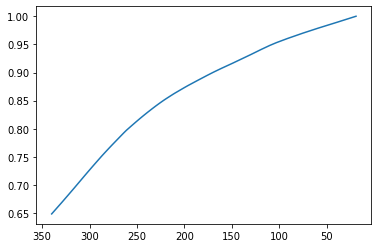

In [37]:
avg_qd = []
cluster_len = []

for i in range(100):

    avg_qd.append(dfcount[dfcount.Quarter_data >= i/100].Quarter_data.mean())
    cluster_len.append(len(dfcount[dfcount.Quarter_data >= i/100].Quarter_data))

plt.plot(cluster_len, avg_qd)
plt.gca().invert_xaxis()
plt.show()

In [38]:
#slight elbow at ~0.85 quartely coverage, use this value to filter data
min_data = 0.85 
dfcount[dfcount.Quarter_data >= min_data]

cluster Type  Price_count  Quarter_data
0          0    D          132      0.916667
8          3    F          227      1.000000
9          3    S          120      0.916667
10         3    T          167      1.000000
16         5    F          198      0.979167
..       ...  ...          ...           ...
311       91    D          288      1.000000
317       93    S          218      0.958333
325       95    T          143      0.958333
327       96    F          132      0.895833
332       98    D          176      1.000000

[119 rows x 4 columns]

## Show Sample Data from First Cluster

<AxesSubplot:xlabel='Date'>

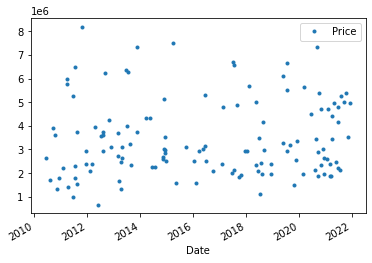

In [39]:
#plot all price point data for an example cluster and housing type
dfplot = dfall[(dfall.cluster == 0) & (dfall.Type == 'D')].sort_values(by=['Date'])
dfplot.plot(x='Date', y='Price', marker='.', linestyle='none')

<AxesSubplot:xlabel='Date'>

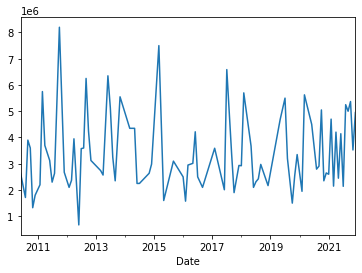

In [40]:
#plot by month
dfplot.groupby(pd.PeriodIndex(dfplot['Date'], freq='M'))['Price'].median().plot()

<AxesSubplot:xlabel='Date'>

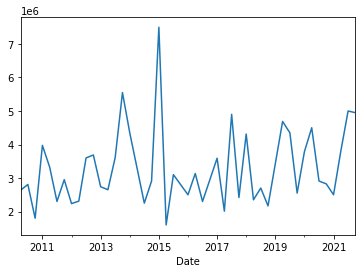

In [41]:
#plot by quarter
dfplot.groupby(pd.PeriodIndex(dfplot['Date'], freq='Q'))['Price'].median().plot()

<AxesSubplot:xlabel='Date'>

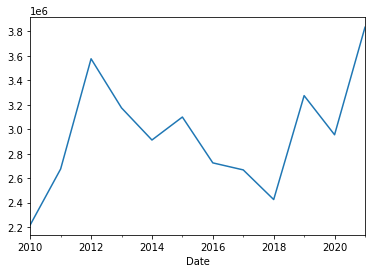

In [42]:
#plot by year
dfplot.groupby(pd.PeriodIndex(dfplot['Date'], freq='Y'))['Price'].median().plot()

In [43]:
#show mean price values by year
dfplot.groupby(pd.PeriodIndex(dfplot['Date'], freq='Y'))['Price'].median()

Date
2010    2217500
2011    2675000
2012    3576544
2013    3175000
2014    2912000
2015    3100000
2016    2725000
2017    2667500
2018    2425000
2019    3275000
2020    2955000
2021    3834500
Freq: A-DEC, Name: Price, dtype: int64

In [44]:
#create final data based on 0.8 quarterly data coverage
df_final = pd.merge(dfall, dfcount[dfcount.Quarter_data >= min_data][['cluster', 'Type']], on=['cluster', 'Type'])

In [45]:
#check size of the final dataframe
df_final.shape

(20167, 27)

In [46]:
df_final.columns

Index(['Price', 'Date', 'Type', 'Postcode', 'loc1', 'loc2', 'loc3', 'Year',
       'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing', 'Grid Ref',
       'Ward', 'Parish', 'Introduced', 'Terminated', 'Altitude', 'Country',
       'Last Updated', 'Quality', 'LSOA Code', 'LSOA Name', 'cluster', 'Lat',
       'Lon'],
      dtype='object')

In [47]:
#check final number of clusters
len(df_final.cluster.unique())

68

In [48]:
#select columns for final dataframe
df_final = df_final[['Price','Date','Year','Type','Lat','Lon','cluster']]

In [49]:
#print file if needed for testing
#df_final.to_csv('data_df_final.csv')

In [50]:
#check to see if any year within each cluster and house type is missing data
df_years_with_data = df_final.groupby(['cluster', 'Type'])['Year'].nunique().reset_index()
df_years_with_data.Year.value_counts()

12    119
Name: Year, dtype: int64

## Examine Regional Trends

<AxesSubplot:xlabel='Date'>

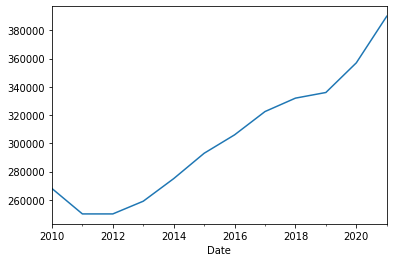

In [51]:
#Pricing trend for all data for housing type D
dfplot_all = df[df.Type =='D']
dfplot_all.groupby(pd.PeriodIndex(dfplot_all['Date'], freq='Y'))['Price'].median().plot()

<AxesSubplot:xlabel='Date'>

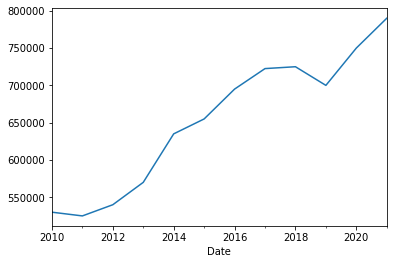

In [52]:
#Pricing trend for Surrey data for housing type D
dfplot_surrey = df[(df.loc3 == 'SURREY') & (df.Type == 'D')]
dfplot_surrey.groupby(pd.PeriodIndex(dfplot_surrey['Date'], freq='Y'))['Price'].median().plot()

<AxesSubplot:xlabel='Date'>

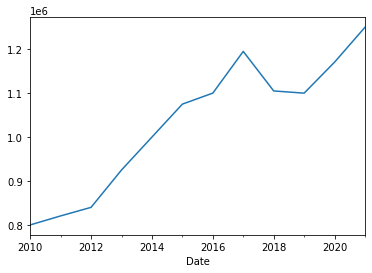

In [53]:
#Pricing trend for Elmbridge data for housing type D
dfplot_elmbridge = df[(df.loc2 == 'ELMBRIDGE') & (df.Type == 'D')]
dfplot_elmbridge.groupby(pd.PeriodIndex(dfplot_elmbridge['Date'], freq='Y'))['Price'].median().plot()

<AxesSubplot:xlabel='Date'>

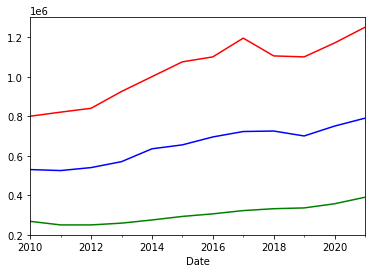

In [54]:
dfplot_all.groupby(pd.PeriodIndex(dfplot_all['Date'], freq='Y'))['Price'].median().plot(color='green')
dfplot_surrey.groupby(pd.PeriodIndex(dfplot_surrey['Date'], freq='Y'))['Price'].median().plot(color='blue')
dfplot_elmbridge.groupby(pd.PeriodIndex(dfplot_elmbridge['Date'], freq='Y'))['Price'].median().plot(color='red')

In [55]:
#Using Surrey data to extract out trend it blends the 
#local Elmbridge fluctuartions with the broader country trends

## Add Surrey Trend Data

In [56]:
#create dateframe for Surrey
dfsurrey = df[df.loc3 == 'SURREY']

In [57]:
#create dataframe with median yearly prices for Surrey by property type
dfsurrey_years = dfsurrey.groupby(['Year', 'Type'])['Price'].median().reset_index()
dfsurrey_years = dfsurrey_years.rename(columns={'Price':'Surrey_med_price'})

In [58]:
#merge Surrey data with original dataframe
dfadjust = pd.merge(df_final, dfsurrey_years, on=['Year','Type'])

## Calculate 1-Year Net Percent Changes (return) 

In [59]:
#create dataframe for calculations
ret_cols = ['Price', 'Surrey_med_price', 'Lat', 'Lon']
dfreturn_year = dfadjust.groupby(['cluster', 'Year', 'Type'])[ret_cols].median().reset_index()

In [60]:
#create a list of unique cluster and year combinations
cluster_type_list = list(zip(dfreturn_year.groupby(['cluster', 'Type']).size().reset_index().cluster,
                dfreturn_year.groupby(['cluster', 'Type']).size().reset_index().Type))

In [61]:
#iterate through each cluster/year series and calculate 1 year change (.pct_change(1))
#(ex. 2021 will have a year-over-year return which is the change from 2020 to 2021)
dfdata1 = pd.DataFrame()
for ct in cluster_type_list:
    df_ct = dfreturn_year[(dfreturn_year.cluster == ct[0]) &
                           (dfreturn_year.Type == ct[1])].sort_values(by='Year', ascending=True)
    df_ct['1y_ret_cluster'] = df_ct['Price'].pct_change(1)
    df_ct['1y_ret_surrey'] = df_ct['Surrey_med_price'].pct_change(1)
    dfdata1 = pd.concat([dfdata1, df_ct])

#remove years that do not have a calcuated return
dfdata1 = dfdata1.dropna()

#calculate the net one year return
dfdata1['1y_ret'] = dfdata1['1y_ret_cluster'] - dfdata1['1y_ret_surrey']

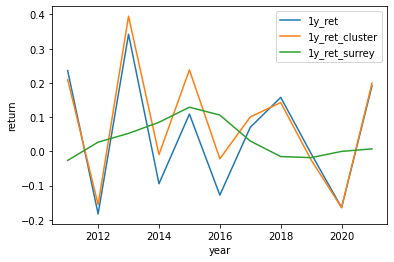

In [62]:
#plot the change for one cluster/type series 
dfplot_rets = dfdata1[(dfdata1.cluster == 8) & (dfdata1.Type == 'F')].sort_values(by=['Year'])

fig,ax = plt.subplots()

for name in ['1y_ret','1y_ret_cluster','1y_ret_surrey']:
    ax.plot(dfplot_rets.Year, dfplot_rets[name] ,label=name)

ax.set_xlabel('year')
ax.set_ylabel('return')
ax.legend(loc='best')

<AxesSubplot:>

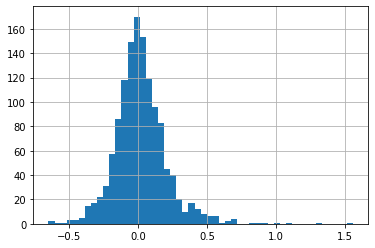

In [63]:
#check the distribution of returns
dfdata1['1y_ret'].hist(bins=50)

In [64]:
#select relevant rows
dfdata1 = dfdata1[['1y_ret', 'cluster', 'Year','Type', 'Lat', 'Lon']]

In [65]:
#output to CSV file
dfdata1.to_csv('data_1year.csv')

## Calculate 3-Year Net Percent Changes (return) 

In [66]:
#iterate through each cluster/year series and calculate 3 year change (.pct_change(3))
#(ex. 2021 will have a 3 year return which is the change from 2008 to 2021)
dfdata3 = pd.DataFrame()
for ct in cluster_type_list:
    df_ct = dfreturn_year[(dfreturn_year.cluster == ct[0]) &
                           (dfreturn_year.Type == ct[1])].sort_values(by='Year', ascending=True)
    df_ct['3y_ret_cluster'] = df_ct['Price'].pct_change(3)
    df_ct['3y_ret_surrey'] = df_ct['Surrey_med_price'].pct_change(3)
    dfdata3 = pd.concat([dfdata3, df_ct])

#remove years that do not have a calcuated return
dfdata3 = dfdata3.dropna()

#calculate the net three year return
dfdata3['3y_ret'] = dfdata3['3y_ret_cluster'] - dfdata3['3y_ret_surrey']

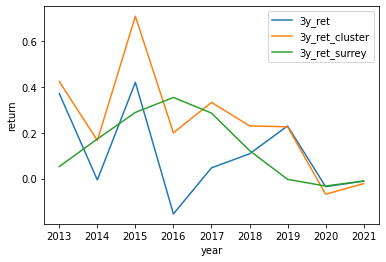

In [67]:
#plot the change for one cluster/type series 
dfplot_rets = dfdata3[(dfdata3.cluster == 8) & (dfdata3.Type == 'F')].sort_values(by=['Year'])

fig,ax = plt.subplots()

for name in ['3y_ret','3y_ret_cluster','3y_ret_surrey']:
    ax.plot(dfplot_rets.Year, dfplot_rets[name] ,label=name)

ax.set_xlabel('year')
ax.set_ylabel('return')
ax.legend(loc='best')

<AxesSubplot:>

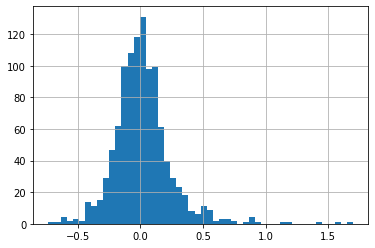

In [68]:
#check the distribution of returns
dfdata3['3y_ret'].hist(bins=50)

In [69]:
#select relevant rows
dfdata3 = dfdata3[['3y_ret', 'cluster', 'Year','Type', 'Lat', 'Lon']]

In [70]:
#output to CSV file
dfdata3.to_csv('data_3year.csv')

## Calculate 5-Year Net Percent Changes (return) 

In [71]:
#iterate through each cluster/year series and calculate 5 year change (.pct_change(5))
#(ex. 2021 will have a 5 year return which is the change from 2006 to 2021)
dfdata5 = pd.DataFrame()
for ct in cluster_type_list:
    df_ct = dfreturn_year[(dfreturn_year.cluster == ct[0]) &
                           (dfreturn_year.Type == ct[1])].sort_values(by='Year', ascending=True)
    df_ct['5y_ret_cluster'] = df_ct['Price'].pct_change(5)
    df_ct['5y_ret_surrey'] = df_ct['Surrey_med_price'].pct_change(5)
    dfdata5 = pd.concat([dfdata5, df_ct])

#remove years that do not have a calcuated return
dfdata5 = dfdata5.dropna()

#calculate the net five year return
dfdata5['5y_ret'] = dfdata5['5y_ret_cluster'] - dfdata5['5y_ret_surrey']

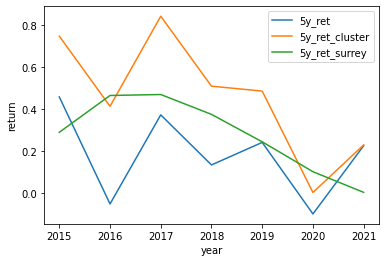

In [72]:
#plot the change for one cluster/type series 
dfplot_rets = dfdata5[(dfdata5.cluster == 8) & (dfdata5.Type == 'F')].sort_values(by=['Year'])

fig,ax = plt.subplots()

for name in ['5y_ret','5y_ret_cluster','5y_ret_surrey']:
    ax.plot(dfplot_rets.Year, dfplot_rets[name] ,label=name)

ax.set_xlabel('year')
ax.set_ylabel('return')
ax.legend(loc='best')

<AxesSubplot:>

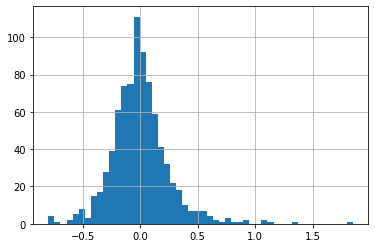

In [73]:
#check the distribution of returns
dfdata5['5y_ret'].hist(bins=50)

In [74]:
#select relevant rows
dfdata5 = dfdata5[['5y_ret', 'cluster', 'Year','Type', 'Lat', 'Lon']]

In [75]:
#output to CSV file
dfdata5.to_csv('data_5year.csv')